In [117]:
import os
import scipy.io
import random
import csv
import numpy as np
import matplotlib.pyplot as plt
import sys, traceback, getpass, time, re
import importlib
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pandas import DataFrame

In [18]:
label_dict = {'Arousal': (0, 3), 'Valence': (1, 0), 'Engagement': (2, 0), 
                   'Liking': (3, 0), 'Familiarity': (4, 0)} # (index, mean)

def get_rating_by_order(rating, order, label, subject_id, clip_id):
    return int(get_label_class(rating[label_dict[label][0]][subject_id][order[subject_id][clip_id]-1], label_dict[label][1]))
    
def get_label_class(rate, mean):
    if rate < mean:
        return '-1'
    else:
        return '+1'
    
def ascertain_to_features(datapath, modality='ECG'):
    mat = scipy.io.loadmat(datapath+'Dt_'+modality+'Features.mat')
    mat = mat[modality+'Features_58']
    mat = np.nan_to_num(mat)
    mat = np.asarray(mat.tolist())
    feature_start_index = 0 if modality is not 'ECG' else -14
    features = mat[:, :, :, feature_start_index:]
    return features[0]

def ascertain_to_personality(datapath):
    pass

def ascertain_to_data_quality(datapath):
    pass

def ascertain_to_order(datapath):
    mat = scipy.io.loadmat(datapath)
    order = mat['PermutationList']
    return order

def ascertain_to_rating(datapath):
    mat = scipy.io.loadmat(datapath)
    disordered_rating = mat['Ratings']
    return disordered_rating

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:102: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-pack

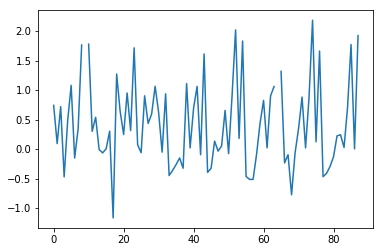

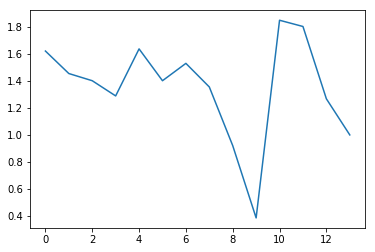

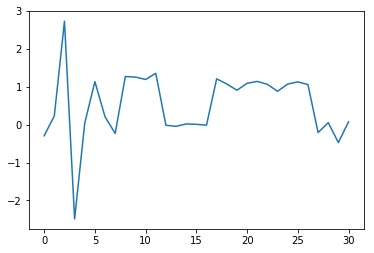

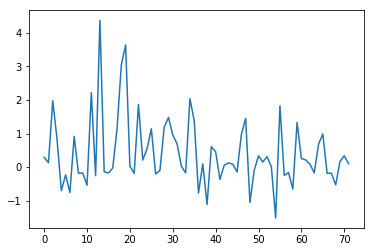

In [34]:
raw_features = {'ECG':[], 'GSR':[], 'EEG':[], 'EMO':[]}
preprocessed_features = {'ECG':[], 'GSR':[], 'EEG':[], 'EMO':[]}
subject_num = 58
clip_num = 36

for key, value in raw_features.items():
    raw_features[key] = ascertain_to_features(datapath='./ASCERTAIN_Features/', modality = key)
    feature_num = raw_features[key].shape[2]
    preprocessed_features[key] = pre.scale(np.nan_to_num(raw_features[key]).reshape(subject_num*clip_num, feature_num))
    plt.plot([x for x in range(len(preprocessed_features[key][555]))], preprocessed_features[key][555])
    plt.show()

In [20]:
personality = ascertain_to_personality('./ASCERTAIN_Features/Dt_Personality.mat')
order = ascertain_to_order('./ASCERTAIN_Features/Dt_Order_Movie.mat')
disordered_rating = ascertain_to_rating('./ASCERTAIN_Features/Dt_SelfReports.mat')

In [36]:
# process ascertain dataset to be in the format of MultimodalDataset
n_instances = 2088
n_cases = 36
labels = ['Arousal', 'Valence']
modalities = ['ECG', 'GSR', 'EEG', 'EMO']
with open('./ascertain_multimodal.csv', 'w', newline='') as csv_file: 
    writer = csv.writer(csv_file)
    
    # 
    csv_data = [[i//36, i%36, get_rating_by_order(disordered_rating, order, 'Arousal', i//36, i%36),
                get_rating_by_order(disordered_rating, order, 'Valence', i//36, i%36),
                ] + [x for m in modalities for x in preprocessed_features[m][i]] for i in range(n_instances)]
    
    # 
    csv_data.insert(0, ['subject_id', 'case_id'] + ['label_'+s for s in labels] + 
                    [s+'_'+str(i) for s in modalities for i in range(preprocessed_features[s].shape[1])])
    writer.writerows(csv_data)
    print(len(csv_data), len(csv_data[0]))

2089 209


In [109]:
# create MultimodalDataset
import ascertain_lib.ascertain_utils
importlib.reload(ascertain_lib.ascertain_utils)
from ascertain_lib.ascertain_utils import MultimodalDataset
md = MultimodalDataset(csv_file='./ascertain_multimodal.csv', selected_modalities=['ECG', 'GSR', 'EEG']
                      , split_mode='within-subject')
md.to_csv('./ascertain_multi_train.csv', './ascertain_multi_test.csv')
df_train, df_test = md.to_pandas()

1


In [185]:
# train svm model
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

def parse_df(df, label_index):
    return df.loc[1:,4:].astype('float').as_matrix(), df.loc[1:,label_index].astype(float).as_matrix()

def calc_acc(trues, preds):
    return sum([1 if preds[i]==trues[i] else 0 for i in range(len(trues))])/len(trues)

arousal_train_x, arousal_train_y = parse_df(df_train, 2)
arousal_svm_model = SVC(C=32, kernel='rbf', gamma=0.001)
arousal_svm_model.fit(arousal_train_x, arousal_train_y) # features start from index 4

valence_train_x, valence_train_y = parse_df(df_train, 3)
valence_svm_model = SVC(C=32, kernel='rbf', gamma=0.001)
valence_svm_model.fit(valence_train_x, valence_train_y)

# predict
arousal_predict_x, arousal_predict_y = parse_df(df_test, 2)
arousal_preds = arousal_svm_model.predict(arousal_predict_x)
print(calc_acc(arousal_predict_y, arousal_preds))

valence_predict_x, valence_predict_y = parse_df(df_test, 3)
valence_preds = valence_svm_model.predict(valence_predict_x)
print(calc_acc(valence_predict_y, valence_preds))

C:\Users\User\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


0.8362068965517241
0.603448275862069
